In [15]:
import tensorflow as tf
from tensorflow import keras
# Importing the pre-trained VGG16 model from Keras applications module
# VGG16 is a deep convolutional neural network trained on ImageNet dataset
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
# Importing ImageDataGenerator — used to load, preprocess, and augment image data during training
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [16]:
dataset_dir = 'caltech-101-img/caltech-101-img'
# Creating an ImageDataGenerator object to preprocess the images
# 'rescale=1.0/255' scales pixel values from [0, 255] to [0, 1] for faster training and better convergence
dataset_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

# here batch_size is the number of images in each batch
batch_size = 2000
# Creating an iterator (generator) that will read images from the dataset directory
dataset_generator = dataset_datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),# Resizes all images to 64x64 pixels to ensure uniform input size
    batch_size=batch_size,
    class_mode='categorical'# Labels are one-hot encoded (used for multi-class classification)
)

Found 9144 images belonging to 102 classes.


In [17]:
#Selecting first batch containing 2000 images as train and second batch containing 2000 images as test data
x_train, y_train =  dataset_generator[0]
x_test, y_test = dataset_generator[1]

print(len(x_train))
print(len(x_test))

2000
2000


In [24]:
#a. Load in a pre-trained CNN model trained on a large dataset
weights_path = 'vgg/vgg/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(64, 64, 3))
# Loading the VGG16 model architecture with the pre-trained weights
# weights=weights_path → loads the model with the specified pre-trained weights
# include_top=False → removes the top (fully connected) layers so we can add our own custom classifier
# input_shape=(64, 64, 3) → specifies the input image size and 3 channels (RGB)

In [25]:
#b. Freeze parameters (weights) in model’s lower convolutional layers
for layer in base_model.layers:
   layer.trainable = False
# Set 'trainable' attribute to False so that these layers' weights will not be updated during training
    # This helps retain the pre-trained feature extraction capability of VGG16
    # and speeds up training since only the newly added layers will be trained

In [26]:
#c. Add custom classifier with several layers of trainable parameters to model
# Flatten the output of the last convolutional block of VGG16 into a 1D vector
# This converts the 3D feature maps (height, width, depth) into a single 1D vector for the fully connected layers
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
# Add a fully connected (dense) layer with 64 neurons
# 'relu' (Rectified Linear Unit) introduces non-linearity and helps the model learn complex patterns
predictions = Dense(102, activation='softmax')(x)
# Add the final output layer with 102 neurons — one for each class in the Caltech-101 dataset
# 'softmax' activation ensures the output is a probability distribution over all 102 classes

# Create the model

model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model

# Compile the model to configure how it will learn
# optimizer='adam' → uses Adam optimizer for efficient gradient descent
# loss='categorical_crossentropy' → suitable for multi-class classification problems
# metrics=['accuracy'] → track accuracy during training and evaluation
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
#optimizer='adam' → Uses the Adam optimizer, which combines the benefits of
# AdaGrad and RMSProp. It adapts the learning rate automatically for each parameter,
# making training faster and more efficient.

# loss='sparse_categorical_crossentropy' → 
# This loss function is used for multi-class classification **when labels are integers** (e.g., 0, 1, 2, ...)
# Instead of one-hot encoded vectors. Each label directly represents a class index.

# metrics=['accuracy'] → 
# This tells Keras to calculate and display the model’s accuracy
# after each epoch, so you can monitor training performance.
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [29]:
#e. Fine-tune hyper parameters and unfreeze more layers as needed
# Reload the VGG16 base model with pre-trained ImageNet weights
# include_top=False removes the top fully connected layers so we can customize them
# input_shape defines the size of our input images (64x64 RGB)
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(64, 64, 3))


# freeze all layers first - this prevents their weights from being updated during training
for layer in base_model.layers:
   layer.trainable = False

    
# Unfreeze the last few layers of the base model to allow fine-tuning
# This helps the model adapt pre-trained features to the new dataset
# Here, the last 2 layers (based on index) are made trainable
for layer in base_model.layers[len(base_model.layers) - 2:]:
   layer.trainable = True
# fine-tuning hyper parameters
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 neurons and ReLU activation
# Larger number of neurons allows learning more complex relationships
x = Dense(512, activation='relu')(x)

# Add dropout layer to reduce overfitting (30% of neurons are randomly dropped during training)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(102, activation='softmax')(x)

# Create the model

# Compile the model with updated settings for fine-tuning
# Adam optimizer with a smaller learning rate (0.001) helps make controlled weight updates
# Loss function is categorical_crossentropy since our labels are one-hot encoded
# Accuracy is tracked as the evaluation metric
model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# training fine tuned model
# Train the fine-tuned model on training data
# batch_size=64 → number of images processed per training step
# epochs=10 → number of full passes through the dataset
# validation_data → data used to evaluate model performance after each epoch
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3420 - loss: 3.1908 - val_accuracy: 0.4825 - val_loss: 2.3973
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5710 - loss: 1.8564 - val_accuracy: 0.5400 - val_loss: 1.9946
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6950 - loss: 1.2046 - val_accuracy: 0.5690 - val_loss: 1.8588
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.7860 - loss: 0.7968 - val_accuracy: 0.6095 - val_loss: 1.6748
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.8655 - loss: 0.4975 - val_accuracy: 0.5990 - val_loss: 1.8219
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.9180 - loss: 0.3055 - val_accuracy: 0.6215 - val_loss: 1.8291
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.9575 - loss: 0.1739 - val_accuracy: 0.6235 - val_loss: 1.7934
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.9625 - loss: 0.1370 - val_accuracy: 0.6360 - val

In [30]:
import matplotlib.pyplot as plt
predicted_value = model.predict(x_test)
# 'model.predict()' returns the model's predicted probabilities for each class
# For example, if there are 102 classes, the output for each test image will be a vector of 102 values (probabilities)

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 867ms/step


In [31]:
labels = list(dataset_generator.class_indices.keys())
# Extract the class labels (category names) from the dataset generator

# 'dataset_generator.class_indices' is a dictionary mapping class names to numeric labels
# Example: {'airplanes': 0, 'bonsai': 1, 'butterfly': 2, ...}

# By using .keys(), we get only the class names (like 'airplanes', 'bonsai', etc.)
# Converting it to a list gives an ordered list of all class labels

Preditcted:  sunflower
Actual:  sunflower


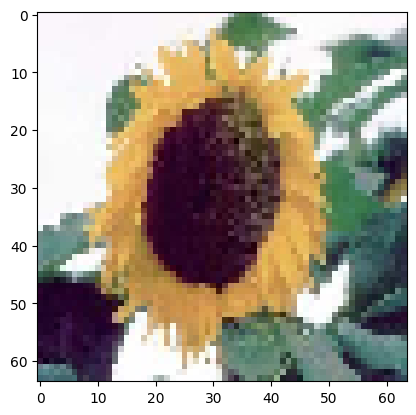

In [34]:
n = 1011
plt.imshow(x_test[n])

# 'predicted_value[n]' gives the probability scores for all 102 classes for image n
# 'np.argmax(predicted_value[n])' returns the index of the class with the highest probability
# 'labels[...]' converts that index back into the corresponding class name
print("Preditcted: ",labels[np.argmax(predicted_value[n])])

# Print the actual (true) class label of the selected image
# 'y_test[n]' contains the true label (one-hot encoded)
# 'np.argmax(y_test[n])' returns the actual class index
# 'labels[...]' maps that index to the original class name
print("Actual: ", labels[np.argmax(y_test[n])])